In [1]:
#Importing important library for NLP
import nltk

In [2]:
'''
nltk has lot many packages but we are going to download wordcount package..
'''
#nltk.download_shell()

'\nnltk has lot many packages but we are going to download wordcount package..\n'

In [3]:
#Importing some important libraries... 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Reading csv file using pandas library..
messages = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [5]:
#Gathering some information..
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
#apply groupby() to collect some info..
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
'''
Now , just thinking to some ways to separate spam and ham..let see if we could separate on basis of length of SMS text.
So , Creating new feature length
'''
messages['length'] = messages['message'].apply(len)

In [8]:
#just a check to see length feature added up or not..it seems okay.
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000620A268278>]],
      dtype=object)

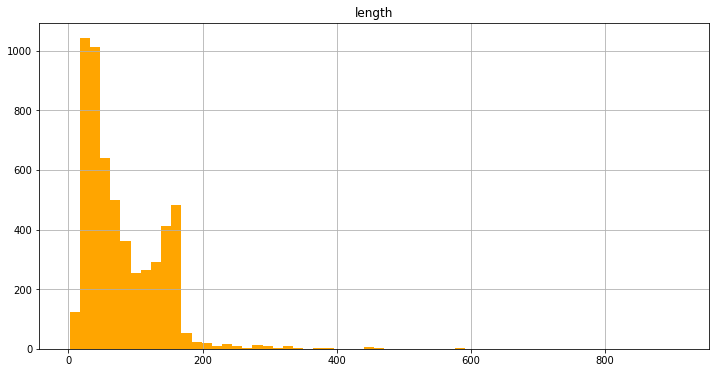

In [9]:
#Now , let as perform EDA to check whether length feature can be a way to separate spam and ham..
messages.hist(bins=60,figsize=(12,6),color='orange')

In [10]:
#just a check.. ;-)
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000620A335780>,
      dtype=object)

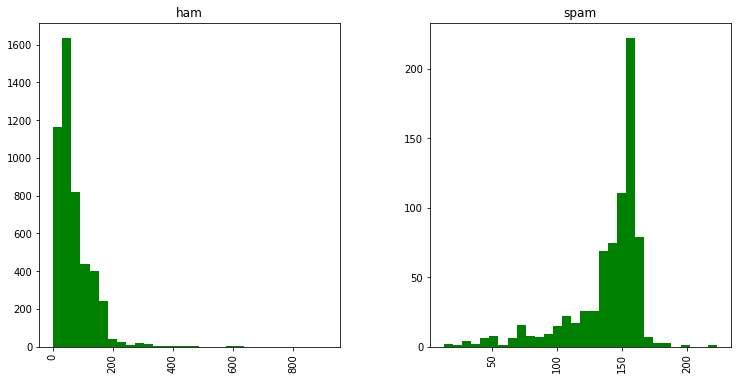

In [11]:
#Separating on the basis of label..and Analysizing..
messages.hist(by='label',bins=30,figsize=(12,6),color='green')

In [12]:
'''
Show it seems that by length size we can distinguish between ham and spam..As above hist() says that ham have short length than
the spam.Avg length of ham is near about 45-50 where as spam has an average age of 160-170
'''

'\nShow it seems that by length size we can distinguish between ham and spam..As above hist() says that ham have short length than\nthe spam.Avg length of ham is near about 45-50 where as spam has an average age of 160-170\n'

In [13]:
#Import string lib.. :-V
import string
from nltk.corpus import stopwords

In [14]:
#NOw , Creating function to clean the text content..
def text_process(mess):
    '''
    1. remove punctations
    2. remove stopwords ie common words
    3. return the list of message
    '''
    punc = [char for char in mess if char not in string.punctuation]
    punc = ''.join(punc)
    return [word for word in punc.split() if word.lower() not in stopwords.words('english')]

In [15]:
#Just a check..it looks text_process worked properly..
messages['message'].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [16]:
#Now implementing it form scratch..importing lib..
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
#making CV to learn about dataset..
bow_transformer  = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [18]:
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x000000620C52B8C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [19]:
#These are total no unique words in the dataframe.. 
print(len(bow_transformer.vocabulary_))

11425


In [20]:
#Now transforming it..
message_bow = bow_transformer.transform(messages['message'])

In [21]:
#message_bow is a sparse matrix where rows are total no of text and column consists of unique vocabularies.. 
message_bow

<5572x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 50548 stored elements in Compressed Sparse Row format>

In [22]:
#Just checking how much matrix is filled..
sparsity = 100*(message_bow.nnz)/(message_bow.shape[0]*message_bow.shape[1])

In [23]:
sparsity

0.07940295412668218

In [24]:
#This is no of non-zero element in the CountVector
message_bow.nnz

50548

Till now we have found the term frequency (TF) ie how much important is a word in the dataset..Cool 

In [25]:
#Now ,let find the Inverse Document Frequency (IDF)and multiple with (TF)...
from sklearn.feature_extraction.text import TfidfTransformer

In [26]:
#Making Tfidf learn learn the bag of words..
ifidf_transform = TfidfTransformer().fit(message_bow)

In [27]:
#Transforming it...
message_ifidf = ifidf_transform.transform(message_bow)

In [28]:
#This is the occurence score..how frequently a particular vocabulary occurs..
ifidf_transform.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

In [29]:
#Text data can't be read by Machine learnig algorithms..So, we use naive_bayes
from sklearn.naive_bayes import MultinomialNB

In [30]:
#Creating object
spam_detection_model = MultinomialNB()

In [31]:
#Making the model learn...
spam_detection_model.fit(message_ifidf,messages['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
#Storing out the predictions..
predictions = spam_detection_model.predict(message_ifidf)

In [33]:
#Importing metrics..
from sklearn.metrics import classification_report

In [34]:
#Printing Classification report..
print(classification_report(messages['label'],predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



98 % it's a very good score...All the above steps we performed are also bunched together in sklearn..So , we need not always perform such a longer process just we will pass the functions in the pipeline.. which is show below..

In [35]:
#Importing to split dataset..
from sklearn.model_selection import train_test_split

In [36]:
message_train , message_test , label_train , label_test = train_test_split(messages['message'],messages['label'],test_size=.3,random_state=101) 

In [37]:
#Just also trying with RFC..
from sklearn.ensemble import RandomForestClassifier

C:\Users\kiit\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [38]:
#Importing pipeline..
from sklearn.pipeline import Pipeline

In [39]:
#Creating object and passing the functions in thier order of execution..
pip = Pipeline([('bow',CountVectorizer(analyzer=text_process)),('tfidf',TfidfTransformer()),('classifier',RandomForestClassifier())])

In [40]:
#Training the dataset..
pip.fit(message_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000000620C52B8C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [41]:
#Storing the prediction
predict = pip.predict(message_test)

In [42]:
#Printing Classification report..
print(classification_report(label_test,predict))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1475
       spam       0.99      0.73      0.84       197

avg / total       0.97      0.97      0.97      1672



We also got a very good result through RFC..